This notebook prepares CDB population data for use in propensity score matching.

As a start, an attempt is made to attach the CDB socio-economic data (in spreadsheet format) to the village point shapefile.

## setup

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [3]:
code_path = Path().absolute()
datafd_path = code_path.parent.parent / 'data'
intmd_outfd_path = code_path.parent.parent / 'output_intmd' / 'match_CDB_vpt_xlsx'
outfd_path = code_path.parent.parent / 'output'

## read in data

### CDB socio-economic data, Reem updated 20230207

In [4]:
CDB_path = datafd_path / 'other' / 'CDB Nat Data 2016 En_Received Dec2017_230207_Reem.xlsx'
# CDB_df_dic = pd.read_excel(CDB_path, sheet_name=None)  # all sheets, key=sheet name
CDB_df_dic = pd.read_excel(CDB_path, sheet_name=['V_2016_E(1)', 'C_2016_E(1)'])
sht_name_lst = list(CDB_df_dic.keys())
# sheet names: ['Q_2016_E', 'V_2016_E(1)', 'V_2016_E(2)', 'V_2016_E(3)', 'C_2016_E(1)', 'C_2016_E(2)', 'D_2016_E(1)']

##### village-level CDB data

In [5]:
vill_sht_name_lst = [sht for sht in sht_name_lst if sht.startswith('V') ]
CDB_v_df_lst = [CDB_df_dic[sht] for sht in vill_sht_name_lst]

##### commune-level CDB data

In [6]:
# comm_sht_name_lst = [sht for sht in sht_name_lst if sht.startswith('C') ]
# CDB_c_df_lst = [CDB_df_dic[sht] for sht in comm_sht_name_lst]

### shapefiles associated with CDB socio-economic data (above), Lok sent 20230407

In [7]:
CDB_shp_fd_path = datafd_path / 'boundaries' / 'Cambodia_Admin-2015'

#### village points

In [8]:
v_pt_gdf = gpd.read_file(CDB_shp_fd_path / 'Villages.shp')  # EPSG:32648

#### commune boundaries

In [9]:
c_bnd_gdf = gpd.read_file(CDB_shp_fd_path / 'Commune Boundary.shp')  # EPSG:32648

#### district boundaries

In [10]:
d_bnd_gdf = gpd.read_file(CDB_shp_fd_path / 'District Boundary.shp')  # EPSG:32648

#### province boundaries

In [11]:
p_bnd_gdf = gpd.read_file(CDB_shp_fd_path / 'Province Boundary.shp')  # EPSG:32648

## preprocess data

##### fix headers of village-level CDB data

In [12]:
CDB_v_df_lst = [df.rename(columns=df.iloc[3]).tail(-4) for df in CDB_v_df_lst]

##### fix headers of commune-level CDB data

In [13]:
# CDB_c_df_lst = [df.rename(columns=df.iloc[3]).tail(-4) for df in CDB_c_df_lst]

##### extract village-level CDB data of interest

In [14]:
CDB_v_df0 = CDB_v_df_lst[0]

## explore data

### in order to join village points with village-level CDB data

#### CDB

In [17]:
CDB_v_df0.head(2)

VillGis          Province   District    Commune       Village 1-FAMILY  \
4  1100201  Banteay Meanchey  Paoy Paet  Paoy Paet  Kbal Spean 1     1914   
5  1100202  Banteay Meanchey  Paoy Paet  Paoy Paet     Baliley 1      998   

  3-MAL_TOT 2-FEM_TOT 73-F_HHH 201-MAL_0_2  ... 1176-Fe_Sel_Furniture  \
4      4000      4203       59         189  ...                     1   
5      1916      2254      117         138  ...                     0   

  1177-Const_Material 1178-T-Worker_Const 1179-Fe_Const_Material  \
4                   2                   7                      4   
5                  20                  51                     22   

  1180-Station_Sports 1181-T-Worker_S_S 1182-Fe_Station_Sports  \
4                   1                 2                      1   
5                   9                17                     13   

  1183-Hair_Services 1184-T-Worker_Hair 1185-Fe_Hair_Services  
4                 20                 47                    24  
5                 18                 41                    29  

[2 rows x 255 columns]

In [19]:
CDB_v_df0.isna().any()  # no NA in first 5 columns

VillGis                   False
Province                  False
District                  False
Commune                   False
Village                   False
                          ...  
1181-T-Worker_S_S          True
1182-Fe_Station_Sports     True
1183-Hair_Services         True
1184-T-Worker_Hair         True
1185-Fe_Hair_Services      True
Length: 255, dtype: bool

In [20]:
CDB_v_df0.VillGis.duplicated().any() # no duplicate VillGis

False

#### village points

In [21]:
v_pt_gdf.shape

(13970, 7)

In [22]:
v_pt_gdf.head(2)

NUMBER  PHUMCODE  VILLAGE   PHUM   XPHUM    YPHUM  \
0       1   1020101  Ou Thom  GUrFM  287800  1494700   
1       2   1020102    Phnum    PñM  285900  1494700   

                         geometry  
0  POINT (287393.080 1495013.949)  
1  POINT (285493.095 1495013.949)

In [23]:
v_pt_gdf.isna().any()  # no NA at all

NUMBER      False
PHUMCODE    False
VILLAGE     False
PHUM        False
XPHUM       False
YPHUM       False
geometry    False
dtype: bool

In [24]:
v_pt_gdf[v_pt_gdf.PHUMCODE.duplicated()]  # 3 records have PHUMCODE = 0

NUMBER  PHUMCODE      VILLAGE      PHUM   XPHUM    YPHUM  \
13968       0         0  Kamlot Tmey   kMltfµI  359829  1267040   
13969       0         0    Pou Boeng  eBaF×bwg  369708  1271369   

                             geometry  
13968  POINT (359421.558 1267355.579)  
13969  POINT (369300.494 1271684.551)

In [25]:
v_pt_gdf[v_pt_gdf.PHUMCODE == 0]

NUMBER  PHUMCODE       VILLAGE       PHUM   XPHUM    YPHUM  \
13967       0         0  Traeung Soek  eRtIgEs¥k  365835        0   
13968       0         0   Kamlot Tmey    kMltfµI  359829  1267040   
13969       0         0     Pou Boeng   eBaF×bwg  369708  1271369   

                             geometry  
13967  POINT (365427.519 1269015.568)  
13968  POINT (359421.558 1267355.579)  
13969  POINT (369300.494 1271684.551)

#### explore matches of village codes: VillGis in CDB v.s. PHUMCODE in village points data

In [21]:
# set of village codes in points and CDB datasets
v_pt_set = set(v_pt_gdf.PHUMCODE)
v_CDB_set = set(CDB_v_df0.VillGis)

In [22]:
len(v_pt_set - v_CDB_set)  
# number of village codes in shapefile but not in spreadsheet

1762

In [23]:
len(v_CDB_set - v_pt_set)
# number of village codes in spreadsheet but not in shapefile

2232

#### left join based on village codes: CDB joined to village points

In [24]:
v_pt_w_CDB_gdf = v_pt_gdf.merge(
    CDB_v_df0[['VillGis', 'Village']],
    how='left',
    left_on='PHUMCODE',
    right_on='VillGis',
    indicator=True,
)

In [25]:
v_pt_w_CDB_gdf.head(2)

NUMBER PHUMCODE  VILLAGE   PHUM   XPHUM    YPHUM  \
0       1  1020101  Ou Thom  GUrFM  287800  1494700   
1       2  1020102    Phnum    PñM  285900  1494700   

                         geometry  VillGis  Village _merge  
0  POINT (287393.080 1495013.949)  1020101  Ou Thum   both  
1  POINT (285493.095 1495013.949)  1020102    Phnum   both

In [26]:
v_pt_w_CDB_gdf._merge.value_counts()  # village codes mostly matched upon first try

both          12206
left_only      1764
right_only        0
Name: _merge, dtype: int64

In [27]:
sum(v_pt_w_CDB_gdf.VILLAGE != v_pt_w_CDB_gdf.Village)  # but many village names not matched

5306

##### 12206-3542 code matched (village point with CDB joined), and village name matched

##### 3542 code matched (village point with CDB joined), but village name not matched

In [28]:
v_pt_w_CDB_gdf.loc[
    (v_pt_w_CDB_gdf.VILLAGE != v_pt_w_CDB_gdf.Village) & (v_pt_w_CDB_gdf._merge == 'both'),
    ['VILLAGE', 'Village']
]  
# 3542 spelling inconsistencies + mismatches of village names among the
# 12206 records with matching village codes

VILLAGE             Village
0                Ou Thom             Ou Thum
7                 Trabek             Trabaek
8                  Khile              Khilek
11         Dang Run Keut      Dang Run Kaeut
14     Prey Changha Keut  Prey Changha Kaeut
...                  ...                 ...
13958         Ou Andoung           O Andoang
13959      Ou Russei Leu      Ou Ressey Loeu
13960       Ou Kro Nhong       Ou Teuk Pleav
13961           Chikreng        Ou Chet Pram
13962            Ou Thom            Sras Pir

[3542 rows x 2 columns]

##### 1764 code not matched (village point without CDB joined)

In [29]:
v_pt_wo_CDB_gdf = v_pt_w_CDB_gdf[v_pt_w_CDB_gdf._merge == 'left_only']
# 1764 village points failed to be found in spreadsheet

In [30]:
set(v_pt_wo_CDB_gdf.PHUMCODE) == (v_pt_set - v_CDB_set)
# their 1764 codes form the same set as 
# the 1762 village codes in shapefile but not in spreadsheet

True

In [31]:
v_pt_set - v_CDB_set
# 1762 village codes in shapefile but not in spreadsheet

{0,
 20070403,
 20070404,
 20070405,
 20070406,
 11010104,
 11010105,
 9060408,
 12050501,
 12050502,
 12050503,
 12050504,
 12050505,
 12050506,
 12050507,
 12050508,
 12050509,
 12050510,
 12050511,
 12050512,
 12050513,
 12050514,
 12050515,
 12050516,
 12050517,
 12050518,
 12050519,
 12050520,
 12050521,
 12050522,
 12050523,
 8011901,
 8011902,
 8011903,
 5070314,
 1040514,
 5070316,
 12050601,
 12050602,
 12050603,
 12050604,
 12050605,
 12050606,
 12050607,
 12050608,
 12050609,
 20070607,
 20070608,
 20070609,
 11010307,
 11010308,
 5071119,
 11010405,
 12050901,
 12050902,
 12050903,
 12050904,
 12050905,
 12050906,
 12050907,
 12050908,
 12050909,
 12050910,
 12050911,
 2130410,
 2130411,
 2130412,
 2130413,
 2130414,
 8020501,
 8020502,
 8020503,
 2130509,
 8012401,
 8012402,
 8012403,
 8012404,
 8012405,
 8012406,
 8012407,
 8012408,
 12051101,
 12051102,
 12051103,
 12051104,
 12051105,
 12051106,
 12051107,
 12051108,
 2040612,
 2040614,
 2040618,
 2040619,
 2040620,
 20

In [32]:
v_pt_wo_CDB_gdf.PHUMCODE.value_counts()  # 3 village points have PHUMCODE = 0 
# 1764 = 1761 village codes + 3 zeros
# 1762 = the same 1761 codes+ 1 zero

0           3
8091201     1
10020103    1
10020102    1
10020101    1
           ..
3120216     1
3120215     1
3120214     1
3120213     1
3161805     1
Name: PHUMCODE, Length: 1762, dtype: int64

In [33]:
{len(str(code)) for code in v_pt_set - v_CDB_set}

{1, 7, 8}

##### 1764 code: 9 3/4?

village points codes to be matched with CDB records

In [34]:
# 1764 code not matched formatted as PPDDCCVV
v_pt_code = v_pt_wo_CDB_gdf['PHUMCODE'].astype(str).str.zfill(8)
v_pt_code

48       01020319
57       01020409
58       01020410
172      01030111
189      01030210
           ...   
13965    24020410
13966    24020411
13967    00000000
13968    00000000
13969    00000000
Name: PHUMCODE, Length: 1764, dtype: object

In [35]:
{len(str(code)) for code in v_pt_code}

{8}

In [36]:
pdcv_id_df = v_pt_code.str.extractall(r'(\d{2})').unstack()
pdcv_id_df

0            
match   0   1   2   3
48     01  02  03  19
57     01  02  04  09
58     01  02  04  10
172    01  03  01  11
189    01  03  02  10
...    ..  ..  ..  ..
13965  24  02  04  10
13966  24  02  04  11
13967  00  00  00  00
13968  00  00  00  00
13969  00  00  00  00

[1764 rows x 4 columns]

In [37]:
pdcv_id_df.isna().any()

match
0  0        False
   1        False
   2        False
   3        False
dtype: bool

In [38]:
pdcv_id_df = pdcv_id_df.astype(int)

In [39]:
pdcv_id_df.columns = [f'{admin_level}id' for admin_level in 'pdcv']

In [40]:
# 1764 village points of interest (with code not matched)
# province, district, commune, village IDs added in respective columns
v_pt_w_pdcvid_gdf = pd.concat([v_pt_wo_CDB_gdf, pdcv_id_df], axis=1)
v_pt_w_pdcvid_gdf

NUMBER  PHUMCODE           VILLAGE          PHUM   XPHUM    YPHUM  \
48         49   1020319  Damnak Preah Ang  dMNak;RBHGgÁ  267053  1490398   
57         58   1020409       Samnang Bak     sMNag)ak;  267940  1490811   
58         59   1020410          Phum 500      PUmi 500  270421  1490920   
172       173   1030111             Knang         kñaMg  329811  1536888   
189       190   1030210        Sras Srang       RsHRsg;  316722  1538011   
...       ...       ...               ...           ...     ...      ...   
13965   13964  24020410          Pu Chrey         BURCI       0        0   
13966   13965  24020411                DA          edeG       0        0   
13967       0         0      Traeung Soek     eRtIgEs¥k  365835        0   
13968       0         0       Kamlot Tmey       kMltfµI  359829  1267040   
13969       0         0         Pou Boeng      eBaF×bwg  369708  1271369   

                             geometry VillGis Village     _merge  pid  did  \
48     POINT (266646.240 1490711.986)     NaN     NaN  left_only    1    2   
57     POINT (267533.233 1491124.982)     NaN     NaN  left_only    1    2   
58     POINT (270014.214 1491233.981)     NaN     NaN  left_only    1    2   
172    POINT (329403.751 1537201.618)     NaN     NaN  left_only    1    3   
189    POINT (316314.855 1538324.608)     NaN     NaN  left_only    1    3   
...                               ...     ...     ...        ...  ...  ...   
13965  POINT (740983.838 1403119.070)     NaN     NaN  left_only   24    2   
13966  POINT (733788.869 1412612.988)     NaN     NaN  left_only   24    2   
13967  POINT (365427.519 1269015.568)     NaN     NaN  left_only    0    0   
13968  POINT (359421.558 1267355.579)     NaN     NaN  left_only    0    0   
13969  POINT (369300.494 1271684.551)     NaN     NaN  left_only    0    0   

       cid  vid  
48       3   19  
57       4    9  
58       4   10  
172      1   11  
189      2   10  
...    ...  ...  
13965    4   10  
13966    4   11  
13967    0    0  
13968    0    0  
13969    0    0  

[1764 rows x 14 columns]

In [41]:
# 1764 village points of interest admin codes aggregated to commune level
v_poi_per_comm_df = v_pt_w_pdcvid_gdf.groupby(['pid', 'did', 'cid']).agg(
    {'vid': lambda x: sorted(list(x))}
)
v_poi_per_comm_df

vid
pid did cid                                     
0   0   0                              [0, 0, 0]
1   2   3                                   [19]
        4                                [9, 10]
    3   1                                   [11]
        2               [10, 11, 13, 14, 15, 16]
...                                          ...
22  1   2               [1, 2, 3, 4, 5, 6, 7, 8]
        5    [9, 10, 11, 12, 13, 14, 15, 16, 17]
    5   1                              [7, 8, 9]
23  1   2                                 [1, 2]
24  2   4                       [10, 11, 12, 13]

[251 rows x 1 columns]

CDB village codes

In [42]:
{len(str(code)) for code in v_CDB_set}

{7, 8}

In [43]:
# all CDB village codes formatted as PPDDCCVV
v_CDB_code = CDB_v_df0['VillGis'].astype(str).str.zfill(8)
v_CDB_code

VillGis
Loading... (need help?)


In [44]:
{len(str(code)) for code in v_CDB_code}

{8}

In [45]:
pdcv_id_df = v_CDB_code.str.extractall(r'(\d{2})').unstack()
pdcv_id_df

0            
match   0   1   2   3
4      01  10  02  01
5      01  10  02  02
6      01  10  02  08
7      01  10  02  12
8      01  10  02  13
...    ..  ..  ..  ..
14437  25  07  14  11
14438  25  07  14  12
14439  25  07  14  13
14440  25  07  14  14
14441  25  07  14  15

[14438 rows x 4 columns]

In [46]:
pdcv_id_df.isna().any()

match
0  0        False
   1        False
   2        False
   3        False
dtype: bool

In [47]:
pdcv_id_df = pdcv_id_df.astype(int)

In [48]:
pdcv_id_df.columns = [f'{admin_level}id' for admin_level in 'pdcv']

In [49]:
# all CDB villages with
# province, district, commune, village IDs added in respective columns
v_CDB_w_pdcvid_df = pd.concat([CDB_v_df0, pdcv_id_df], axis=1)
v_CDB_w_pdcvid_df

VillGis          Province      District    Commune          Village  \
4       1100201  Banteay Meanchey     Paoy Paet  Paoy Paet     Kbal Spean 1   
5       1100202  Banteay Meanchey     Paoy Paet  Paoy Paet        Baliley 1   
6       1100208  Banteay Meanchey     Paoy Paet  Paoy Paet      Toul Prasat   
7       1100212  Banteay Meanchey     Paoy Paet  Paoy Paet     Kbal Spean 2   
8       1100213  Banteay Meanchey     Paoy Paet  Paoy Paet         Kbal Koh   
...         ...               ...           ...        ...              ...   
14437  25071411      Tboung Khmum  Tboung Khmum  Tonle Bet  Tonle Bet Kraom   
14438  25071412      Tboung Khmum  Tboung Khmum  Tonle Bet    Tonle Bet Leu   
14439  25071413      Tboung Khmum  Tboung Khmum  Tonle Bet            Tahuy   
14440  25071414      Tboung Khmum  Tboung Khmum  Tonle Bet        Tonle Bet   
14441  25071415      Tboung Khmum  Tboung Khmum  Tonle Bet           Yaysor   

      1-FAMILY 3-MAL_TOT 2-FEM_TOT 73-F_HHH 201-MAL_0_2  ...  \
4         1914      4000      4203       59         189  ...   
5          998      1916      2254      117         138  ...   
6          283       619       566       72          37  ...   
7         1228      2539      2554      120          71  ...   
8          753      1525      1902      186          69  ...   
...        ...       ...       ...      ...         ...  ...   
14437      324       649       698       25          28  ...   
14438      166       328       347       16          19  ...   
14439       76       174       182       14           5  ...   
14440      203       548       503       15          37  ...   
14441      204       464       488       35          26  ...   

      1180-Station_Sports 1181-T-Worker_S_S 1182-Fe_Station_Sports  \
4                       1                 2                      1   
5                       9                17                     13   
6                       0                 0                      0   
7                       1                 4                      2   
8                       2                 4                      2   
...                   ...               ...                    ...   
14437                  10                24                     10   
14438                   0                 0                      0   
14439                   0                 0                      0   
14440                   0                 0                      0   
14441                   0                 0                      0   

      1183-Hair_Services 1184-T-Worker_Hair 1185-Fe_Hair_Services pid did cid  \
4                     20                 47                    24   1  10   2   
5                     18                 41                    29   1  10   2   
6                      0                  0                     0   1  10   2   
7                     15                 22                    17   1  10   2   
8                      6                 24                    24   1  10   2   
...                  ...                ...                   ...  ..  ..  ..   
14437                  8                 16                     4  25   7  14   
14438                  5                  5                     5  25   7  14   
14439                  0                  0                     0  25   7  14   
14440                  0                  0                     0  25   7  14   
14441                  1                  1                     0  25   7  14   

      vid  
4       1  
5       2  
6       8  
7      12  
8      13  
...    ..  
14437  11  
14438  12  
14439  13  
14440  14  
14441  15  

[14438 rows x 259 columns]

In [50]:
# CDB admin codes aggregated to commune level
v_CDB_per_comm_df = v_CDB_w_pdcvid_df.groupby(['pid', 'did', 'cid']).agg(
    {'vid': lambda x: sorted(list(x))}
)
v_CDB_per_comm_df

vid
pid did cid                                                   
1   2   1    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
        2                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        3    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
        4                             [1, 2, 3, 4, 5, 6, 7, 8]
        5                             [1, 2, 3, 4, 5, 6, 7, 8]
...                                                        ...
25  7   10                 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        11   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
        12   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
        13   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
        14   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...

[1646 rows x 1 columns]

In [51]:
# type 1 communes in which village #1 supposedly matched, but 
# there are additional/new villages not matched
new_vill_in_comm_df = v_poi_per_comm_df[
    v_poi_per_comm_df.vid.apply(lambda lst: min(lst) != 1)
]

In [52]:
# type 2 communes in which village #1 not matched, supposedly
# the commune doesn't exist in the spreadsheet at all?
new_comm_df = v_poi_per_comm_df[
    v_poi_per_comm_df.vid.apply(lambda lst: min(lst) == 1)
]

In [53]:
# the above two types of communes are mutually exclusive & exhaustive
v_poi_per_comm_df.shape[0] == new_vill_in_comm_df.shape[0] + new_comm_df.shape[0]

True

In [54]:
# type 1 communes with village IDs not matched (among the 1764, to be matched) 
# compared with all village IDs in the commune in the spreadsheet (candidates for matching)
new_vill_in_comm_df.merge(
    v_CDB_per_comm_df,
    how='left',
    on=['pid', 'did', 'cid'],
    suffixes=['_to_be_matched', '_candidates'],
    indicator=True
)

vid_to_be_matched  \
pid did cid                                        
0   0   0                              [0, 0, 0]   
1   2   3                                   [19]   
        4                                [9, 10]   
    3   1                                   [11]   
        2               [10, 11, 13, 14, 15, 16]   
...                                          ...   
20  8   4                              [3, 4, 5]   
        5            [9, 10, 11, 12, 13, 14, 15]   
22  1   5    [9, 10, 11, 12, 13, 14, 15, 16, 17]   
    5   1                              [7, 8, 9]   
24  2   4                       [10, 11, 12, 13]   

                                                vid_candidates     _merge  
pid did cid                                                                
0   0   0                                                  NaN  left_only  
1   2   3    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...       both  
        4                             [1, 2, 3, 4, 5, 6, 7, 8]       both  
    3   1    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15...       both  
        2                      [1, 2, 3, 4, 5, 6, 7, 8, 9, 12]       both  
...                                                        ...        ...  
20  8   4                                               [1, 2]       both  
        5                             [1, 2, 3, 4, 5, 6, 7, 8]       both  
22  1   5                             [1, 2, 3, 4, 5, 6, 7, 8]       both  
    5   1                                   [1, 2, 3, 4, 5, 6]       both  
24  2   4                          [1, 2, 3, 4, 5, 6, 7, 8, 9]       both  

[107 rows x 3 columns]

In [55]:
# village points in province 1, district 10, commune 2
v_pt_gdf[v_pt_gdf.PHUMCODE.astype(str).str.startswith('11002')]

NUMBER  PHUMCODE               VILLAGE         PHUM   XPHUM    YPHUM  \
634     635   1100201            Nimit Muoy     nimitþ 1  255385  1506304   
635     636   1100202             Nimit Pir     nimitþ 2  258167  1505467   
636     637   1100203             Nimit Bei     nimitþ 3  256773  1505828   
637     638   1100204            Nimit Buon     nimitþ 4  257557  1505729   
638     639   1100205              Ou Chrov      GUreRCA  257781  1505406   
639     640   1100206            Dong Aranh    dugGarBaØ  254200  1504900   
640     641   1100207               Souriya       sUriya  249241  1509122   
641     642   1100208           Nimit Thmei    nimitþfµI  252700  1506700   
642     643   1100209              Thma Sen        fµsin  256200  1510200   
643     644   1100210           Koun Damrei      kUndMrI  249130  1507430   
644     645   1100211             Koub Thom        kUbFM  248726  1503538   
645     646   1100212           Anlong Svay    Gnøg;sVay  250338  1502668   
646     647   1100213  Reaksmei Serey Pheap  rsµIesrIPaB  247528  1503791   
647     648   1100214       Reaksmei Samaki   rsµIsamKÁI  245910  1501568   
648     649   1100215              Sokh San      suxsanþ  244566  1505017   

                           geometry  
634  POINT (254978.334 1506617.864)  
635  POINT (257760.312 1505780.870)  
636  POINT (256366.323 1506141.867)  
637  POINT (257150.317 1506042.868)  
638  POINT (257374.315 1505719.870)  
639  POINT (253793.343 1505213.875)  
640  POINT (248834.383 1509435.843)  
641  POINT (252293.355 1507013.861)  
642  POINT (255793.328 1510513.833)  
643  POINT (248723.383 1507743.857)  
644  POINT (248319.385 1503851.887)  
645  POINT (249931.372 1502981.894)  
646  POINT (247121.395 1504104.886)  
647  POINT (245503.407 1501881.904)  
648  POINT (244159.418 1505330.877)

In [56]:
v_pt_gdf[v_pt_gdf.PHUMCODE.astype(str).str.startswith('11001')]

NUMBER  PHUMCODE            VILLAGE        PHUM   XPHUM    YPHUM  \
623     624   1100101         Kbal Spean    k,als<an  236200  1510800   
624     625   1100102            Baliley    )alielyü  237100  1510200   
625     626   1100103    Kilou Lekh Buon  KILÚelxbYn  238700  1509000   
626     627   1100104        Tuol Pongro      TYlBRg  242356  1512587   
627     628   1100105           Prey Kob      éRBKb;  242447  1516291   
628     629   1100106  Andoung Thma Meas  GNþÚgfµmas  244819  1507752   
629     630   1100107         Stueng Bat     sÞwgbt;  241771  1506643   
630     631   1100108        Tuol Prasat   TYlR)asaT  240960  1514209   
631     632   1100109       Procheathoam     RbCaFmµ  239425  1511452   
632     633   1100110           Ou Neang      GUrnag  244180  1516819   
633     634   1100111          Ou Russei    GUrbJsSI  243323  1513465   

                           geometry  
623  POINT (235793.485 1511113.834)  
624  POINT (236693.478 1510513.838)  
625  POINT (238293.465 1509313.847)  
626  POINT (241949.438 1512900.818)  
627  POINT (242040.438 1516604.788)  
628  POINT (244412.417 1508065.855)  
629  POINT (241364.440 1506956.865)  
630  POINT (240553.449 1514522.805)  
631  POINT (239018.460 1511765.828)  
632  POINT (243773.425 1517132.784)  
633  POINT (242916.430 1513778.810)

In [57]:
v_pt_gdf[v_pt_gdf.PHUMCODE.astype(str).str.startswith('10203')]

NUMBER  PHUMCODE           VILLAGE          PHUM   XPHUM    YPHUM  \
30      31   1020301       Pralay Char      RbLaycar  279095  1487835   
31      32   1020302     Rongvean Lech      rgVanlic  277867  1487797   
32      33   1020303     Rongvean Keut     rgVanekIt  279100  1487800   
33      34   1020304     Chamnaom Lech     cMeNamlic  277074  1487378   
34      35   1020305     Chamnaom Keut    cMeNamekIt  276800  1486800   
35      36   1020306   Roung Kou Daeum  erageKakedIm  276500  1486000   
36      37   1020307  Roung Kou Kandal  erageKakNþal  276500  1485800   
37      38   1020308   Roung Kou Chong   erageKakcug  276500  1485500   
38      39   1020309    Peam Roung Kou    BamerageKa  276400  1485200   
39      40   1020310            Ta Sal         tasl;  276455  1483834   
40      41   1020311      Chuor Khchas      CYrxÞas;  278600  1483400   
41      42   1020312        Boeng Tras       bwgRts;  280100  1483100   
42      43   1020313        Dang Trang        dgRtag  281600  1483900   
43      44   1020314          Sre Prey        ERséRB  279700  1484600   
44      45   1020315       Bos Tonloab    busSTnøab;  280500  1485900   
45      46   1020316           Ta  Bun        tabun  279200  1484600   
46      47   1020317       Kouk Ponley      eKakBénø  280700  1486500   
47      48   1020318        Say Samaan     saysam:an  266918  1486788   
48      49   1020319  Damnak Preah Ang  dMNak;RBHGgÁ  267053  1490398   

                          geometry  
30  POINT (278688.146 1488149.003)  
31  POINT (277460.156 1488111.004)  
32  POINT (278693.146 1488114.004)  
33  POINT (276667.162 1487692.007)  
34  POINT (276393.164 1487114.012)  
35  POINT (276093.166 1486314.018)  
36  POINT (276093.166 1486114.020)  
37  POINT (276093.166 1485814.022)  
38  POINT (275993.167 1485514.024)  
39  POINT (276048.166 1484148.035)  
40  POINT (278193.149 1483714.038)  
41  POINT (279693.138 1483414.040)  
42  POINT (281193.126 1484214.033)  
43  POINT (279293.141 1484914.028)  
44  POINT (280093.135 1486214.018)  
45  POINT (278793.145 1484914.028)  
46  POINT (280293.134 1486814.013)  
47  POINT (266511.240 1487102.014)  
48  POINT (266646.240 1490711.986)

In [58]:
# type 2 communes
new_comm_df

vid
pid did cid                                             
1   5   4                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    6   1                                [1, 2, 3, 4, 5]
2   11  3                                   [1, 2, 3, 4]
    14  2                       [1, 3, 4, 5, 6, 7, 8, 9]
3   4   1    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
...                                                  ...
20  2   10                            [1, 2, 3, 4, 5, 6]
    5   6        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    7   1                       [1, 2, 3, 4, 5, 6, 7, 8]
22  1   2                       [1, 2, 3, 4, 5, 6, 7, 8]
23  1   2                                         [1, 2]

[144 rows x 1 columns]

In [61]:
v_pt_gdf[v_pt_gdf.PHUMCODE.astype(str).str.startswith('10504')]

NUMBER  PHUMCODE        VILLAGE      PHUM   XPHUM    YPHUM  \
369     370   1050401        Banlech     bnøic  268000  1497400   
370     371   1050402  Neak Ta Chhor   GñktaQr  267400  1498100   
371     372   1050403       Samraong    sMerag  267003  1498826   
372     373   1050404   Kampong Reab  kMBg;rab  265547  1499937   
373     374   1050405          Thmei       fµI  266256  1499489   
374     375   1050406    Thmenh Trei   eFµjRtI  265118  1500360   
375     376   1050407      Bat Trang   bt;Rtg;  264500  1500300   
376     377   1050408       Anhchanh    GBa©aj  269600  1498900   
377     378   1050409            Wat       vtþ  266800  1499100   
378     379   1050410         Kandal     kNþal  266397  1499287   

                           geometry  
369  POINT (267593.234 1497713.931)  
370  POINT (266993.239 1498413.925)  
371  POINT (266596.242 1499139.920)  
372  POINT (265140.253 1500250.911)  
373  POINT (265849.248 1499802.915)  
374  POINT (264711.257 1500673.908)  
375  POINT (264093.262 1500613.909)  
376  POINT (269193.222 1499213.919)  
377  POINT (266393.243 1499413.918)  
378  POINT (265990.247 1499600.916)

In [62]:
v_pt_gdf[v_pt_gdf.PHUMCODE.astype(str).str.startswith('10505')]

NUMBER  PHUMCODE        VILLAGE       PHUM   XPHUM    YPHUM  \
379     380   1050501  Souphi Cheung   sUPIeCIg  265900  1509100   
380     381   1050502  Souphi Kandal  sUPIkNþal  265900  1508900   
381     382   1050503  Souphi Tboung   sUPIt,Úg  266000  1508600   
382     383   1050504      Kouk Chak     eKakck  267700  1509200   
383     384   1050505     Kouk Prich   eKakRBic  264685  1507172   
384     385   1050506     Chak Thmei      ckfµI  267085  1509659   

                           geometry  
379  POINT (265493.252 1509413.839)  
380  POINT (265493.252 1509213.841)  
381  POINT (265593.251 1508913.843)  
382  POINT (267293.238 1509513.838)  
383  POINT (264278.261 1507485.855)  
384  POINT (266678.243 1509972.835)

In [63]:
v_pt_gdf[v_pt_gdf.PHUMCODE.astype(str).str.startswith('10601')]

NUMBER  PHUMCODE       VILLAGE       PHUM   XPHUM    YPHUM  \
405     406   1060101  Kampong Svay  kMBg;sVay  281000  1503500   
406     407   1060102       Kang Va      kgv:a  280048  1507741   
407     408   1060103      Phum Pir     PUmi 2  280300  1504900   
408     409   1060104        Pongro        BRg  280059  1506090   
409     410   1060105        Souphi       sUPI  281066  1503197   

                           geometry  
405  POINT (280593.134 1503813.881)  
406  POINT (279641.142 1508054.848)  
407  POINT (279893.139 1505213.870)  
408  POINT (279652.141 1506403.861)  
409  POINT (280659.133 1503510.883)

In [64]:
v_pt_gdf[v_pt_gdf.PHUMCODE.astype(str).str.startswith('10602')]

NUMBER  PHUMCODE        VILLAGE       PHUM   XPHUM    YPHUM  \
410     411   1060201  Koh Pong Satv  ekaHBgstV  285838  1502562   
411     412   1060202        Ta Sokh      tasux  286690  1502576   
412     413   1060203     Preah Angk     RBHGgÁ  287212  1501859   
413     414   1060204   Snay Dangkot  sñaydgÁt;  288200  1502100   
414     415   1060205     Angkea Bos   GgÁabusS  289200  1502200   

                           geometry  
410  POINT (285431.096 1502875.888)  
411  POINT (286283.089 1502889.888)  
412  POINT (286805.085 1502172.893)  
413  POINT (287793.078 1502413.891)  
414  POINT (288793.070 1502513.890)

### potential of population variables in the commune boundaries shapefile

In [15]:
c_bnd_gdf.shape # 1652 per Google

(1625, 8)

In [16]:
c_bnd_gdf.columns

Index(['COMM_CODE', 'COMM_NAME', 'Establishm', 'Total', 'Male', 'Female',
       'References', 'geometry'],
      dtype='object')

In [21]:
c_bnd_gdf.isna().any()  # no NA

COMM_CODE     False
COMM_NAME     False
Establishm    False
Total         False
Male          False
Female        False
References    False
geometry      False
dtype: bool

In [17]:
c_bnd_gdf.References.value_counts()  # f"Economic_Census_of_Cambodia_2011_{province}__01.03.2012.pdf"

Economic_Census_of_Cambodia_2011_KampongCham__01.03.2012.pdf        173
Economic_Census_of_Cambodia_2011_Kandal__01.03.2012.pdf             127
Economic_Census_of_Cambodia_2011_PreyVeng__01.03.2012.pdf           116
Economic_Census_of_Cambodia_2011_SiemReap__01.03.2012.pdf           100
Economic_Census_of_Cambodia_2011_Takeo__01.03.2012.pdf              100
Economic_Census_of_Cambodia_2011_Battambang__01.03.2012.pdf          96
Economic_Census_of_Cambodia_2011_PhnomPenh__01.03.2012.pdf           96
Economic_Census_of_Cambodia_2011_Kampot__01.03.2012.pdf              92
Economic_Census_of_Cambodia_2011_KampongSpeu__01.03.2012.pdf         87
Economic_Census_of_Cambodia_2011_KampongThom__01.03.2012.pdf         81
Economic_Census_of_Cambodia_2011_SvayRieng__01.03.2012.pdf           80
Economic_Census_of_Cambodia_2011_KampongChhnang__01.03.2012.pdf      69
Economic_Census_of_Cambodia_2011_BanteayMeanchey__01.03.2012.pdf     64
Economic_Census_of_Cambodia_2011_PreahVihear__01.03.2012.pdf         52
Economic_Census_of_Cambodia_2011_RatanakKiri__01.03.2012.pdf         50
Economic_Census_of_Cambodia_2011_Pursat__01.03.2012.pdf              49
Economic_Census_of_Cambodia_2011_Kratie__01.03.2012.pdf              46
Economic_Census_of_Cambodia_2011_StungTreng__01.03.2012.pdf          34
Economic_Census_of_Cambodia_2011_KohKong__01.03.2012.pdf             29
Economic_Census_of_Cambodia_2011_PreahSihanouk__01.03.2012.pdf       26
Economic_Census_of_Cambodia_2011_OtdarMeanchey__01.03.2012.pdf       24
Economic_Census_of_Cambodia_2011_Mondulkiri__01.03.2012.pdf          21
Economic_Census_of_Cambodia_2011_Pailin__01.03.2012.pdf               8
Economic_Census_of_Cambodia_2011_Kep__01.03.2012.pdf                  5
Name: References, dtype: int64

In [18]:
all(c_bnd_gdf.Total == c_bnd_gdf.Male + c_bnd_gdf.Female)

True

In [19]:
sum(c_bnd_gdf.Total)  # 16,590,000 per Google

1699656.0

<AxesSubplot:>

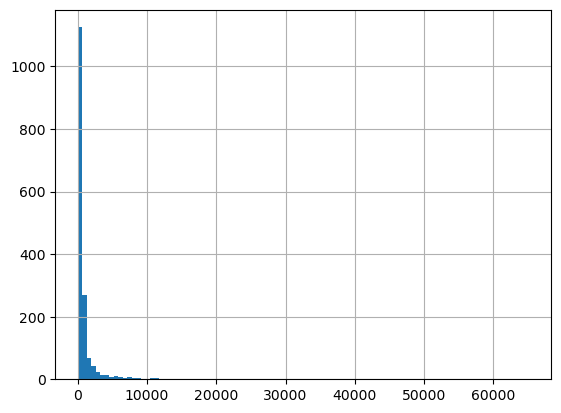

In [33]:
c_bnd_gdf.Total.hist(bins=100)

In [25]:
CDB_v_df0[['3-MAL_TOT', '2-FEM_TOT']].sum().sum()  # the right magnitude

15512695

## enrich village points with commune, district, province info

### add unique ID to each shapefile

In [15]:
for i, gdf in enumerate([v_pt_gdf, c_bnd_gdf, d_bnd_gdf, p_bnd_gdf]):
    gdf.reset_index(inplace=True)
    admin_level = 'vcdp'[i]
    gdf.rename(columns={'index': f'unique_id'}, inplace=True)
    gdf.columns = [f'{c}_{admin_level}' if c != 'geometry' else c for c in gdf.columns ]
    assert gdf[f'unique_id_{admin_level}'].is_unique

### sanity checks

In [16]:
for gdf in [v_pt_gdf, c_bnd_gdf, d_bnd_gdf, p_bnd_gdf]:
    geometries = gdf.loc[:, gdf.columns.str.contains('geometry')].squeeze()
    print(set(geometries.geom_type))
    assert all(geometries.is_valid)  # all geometries are valid
    print(gdf.columns)
    assert all(gdf.isna().any() == False)  # no NA

{'Point'}
Index(['unique_id_v', 'NUMBER_v', 'PHUMCODE_v', 'VILLAGE_v', 'PHUM_v',
       'XPHUM_v', 'YPHUM_v', 'geometry'],
      dtype='object')
{'Polygon', 'MultiPolygon'}
Index(['unique_id_c', 'COMM_CODE_c', 'COMM_NAME_c', 'Establishm_c', 'Total_c',
       'Male_c', 'Female_c', 'References_c', 'geometry'],
      dtype='object')
{'Polygon', 'MultiPolygon'}
Index(['unique_id_d', 'DIST_CODE_d', 'DIST_NAME_d', 'Total_d', 'Male_d',
       'Female_d', 'Establishm_d', 'References_d', 'geometry'],
      dtype='object')
{'Polygon', 'MultiPolygon'}
Index(['unique_id_p', 'PROV_NAME_p', 'Establishm_p', 'Total_p', 'Male_p',
       'Female_p', 'References_p', 'PROV_CODE_p', 'Hectares_p', 'geometry'],
      dtype='object')


### enrich

In [17]:
# Enrich with commune info
v_pt_w_c_gdf = v_pt_gdf.sjoin(
    c_bnd_gdf,
    how='left',
    predicate='within',
    rsuffix='c'
)

In [18]:
v_pt_w_c_gdf[v_pt_w_c_gdf.index_c.isna()]  # 19 village points not enriched

unique_id_v  NUMBER_v  PHUMCODE_v              VILLAGE_v  \
3181          3181      3182     4010201             Chhnok Tru   
3182          3182      3183     4010202          Kampong Preah   
3183          3183      3184     4010203               Seh Slab   
3198          3198      3199     4010410            Kampong Uor   
5766          5766      5767     6080703              Peam Bang   
7436          7436      7437     9020101              Koh Sdach   
7445          7445      7446     9030101            Chrouy Pras   
10121        10121     10122    15020402              Phum Prek   
10122        10122     10123    15020403               Chamraoh   
10123        10123     10124    15020404               Koh  Kev   
10225        10225     10226    15030501              Phum Muoy   
10226        10226     10227    15030502               Phum Pir   
10227        10227     10228    15030503               Phum Bei   
10229        10229     10230    15030505              Phum Pram   
11600        11600     11601    18010501              Koh Touch   
11602        11602     11603    18010503             Preak Svay   
11603        11603     11604    18010504  Mondol Kohrongsanleum   
12742        12742     12743    21030402        Kampong Krasang   
13876        13876     13877    23020101                    Keb   

                  PHUM_v  XPHUM_v  YPHUM_v                        geometry  \
3181             qñúkRTU   440763  1382939  POINT (440354.976 1383253.813)   
3182            kMBg;RBH   442076  1383021  POINT (441667.966 1383335.813)   
3183            esHsøab;   446683  1379919  POINT (446274.936 1380233.838)   
3198            kMBg;GYr   450720  1375965  POINT (450311.910 1376279.868)   
5766              Bam)ag   419613  1407864  POINT (419205.113 1408178.624)   
7436            ekaHesþc   290615  1209793  POINT (290207.989 1210108.959)   
7445           eRCayRbs;   292859  1254998  POINT (292451.991 1255313.668)   
10121           PUmiERBk   393500  1413500  POINT (393092.299 1413814.572)   
10122             cMeraH   393300  1413700  POINT (392892.301 1414014.571)   
10123            ekaHEkv   393100  1413900  POINT (392692.302 1414214.569)   
10225             PUmi 1   413900  1391000  POINT (413492.162 1391314.743)   
10226             PUmi 2   413900  1391900  POINT (413492.161 1392214.736)   
10227             PUmi 3   414900  1391300  POINT (414492.154 1391614.741)   
10229             PUmi 5   414900  1390400  POINT (414492.155 1390714.747)   
11600            ekaHtUc   311525  1179262  POINT (311117.850 1179578.141)   
11602           ERBksVay   309075  1190453  POINT (308667.868 1190769.073)   
11603  mNÐlekaHr:ugsnøwm   313801  1174350  POINT (313393.834 1174666.170)   
12742        kMBg;RksaMg   507243  1192840  POINT (506834.667 1193156.105)   
13876                Ekb   426030  1158590  POINT (425622.167 1158906.265)   

       index_c  unique_id_c COMM_CODE_c COMM_NAME_c  Establishm_c  Total_c  \
3181       NaN          NaN         NaN         NaN           NaN      NaN   
3182       NaN          NaN         NaN         NaN           NaN      NaN   
3183       NaN          NaN         NaN         NaN           NaN      NaN   
3198       NaN          NaN         NaN         NaN           NaN      NaN   
5766       NaN          NaN         NaN         NaN           NaN      NaN   
7436       NaN          NaN         NaN         NaN           NaN      NaN   
7445       NaN          NaN         NaN         NaN           NaN      NaN   
10121      NaN          NaN         NaN         NaN           NaN      NaN   
10122      NaN          NaN         NaN         NaN           NaN      NaN   
10123      NaN          NaN         NaN         NaN           NaN      NaN   
10225      NaN          NaN         NaN         NaN           NaN      NaN   
10226      NaN          NaN         NaN         NaN           NaN      NaN   
10227      NaN          NaN         NaN         NaN           NaN      NaN   
10229      Na

In [19]:
# Enrich with district info
v_pt_w_cd_gdf = v_pt_w_c_gdf.sjoin(
    d_bnd_gdf,
    how='left',
    predicate='within',
    rsuffix='d'
)

In [20]:
v_pt_w_cd_gdf[v_pt_w_cd_gdf.index_d.isna()]  # the same 19 points

unique_id_v  NUMBER_v  PHUMCODE_v              VILLAGE_v  \
3181          3181      3182     4010201             Chhnok Tru   
3182          3182      3183     4010202          Kampong Preah   
3183          3183      3184     4010203               Seh Slab   
3198          3198      3199     4010410            Kampong Uor   
5766          5766      5767     6080703              Peam Bang   
7436          7436      7437     9020101              Koh Sdach   
7445          7445      7446     9030101            Chrouy Pras   
10121        10121     10122    15020402              Phum Prek   
10122        10122     10123    15020403               Chamraoh   
10123        10123     10124    15020404               Koh  Kev   
10225        10225     10226    15030501              Phum Muoy   
10226        10226     10227    15030502               Phum Pir   
10227        10227     10228    15030503               Phum Bei   
10229        10229     10230    15030505              Phum Pram   
11600        11600     11601    18010501              Koh Touch   
11602        11602     11603    18010503             Preak Svay   
11603        11603     11604    18010504  Mondol Kohrongsanleum   
12742        12742     12743    21030402        Kampong Krasang   
13876        13876     13877    23020101                    Keb   

                  PHUM_v  XPHUM_v  YPHUM_v                        geometry  \
3181             qñúkRTU   440763  1382939  POINT (440354.976 1383253.813)   
3182            kMBg;RBH   442076  1383021  POINT (441667.966 1383335.813)   
3183            esHsøab;   446683  1379919  POINT (446274.936 1380233.838)   
3198            kMBg;GYr   450720  1375965  POINT (450311.910 1376279.868)   
5766              Bam)ag   419613  1407864  POINT (419205.113 1408178.624)   
7436            ekaHesþc   290615  1209793  POINT (290207.989 1210108.959)   
7445           eRCayRbs;   292859  1254998  POINT (292451.991 1255313.668)   
10121           PUmiERBk   393500  1413500  POINT (393092.299 1413814.572)   
10122             cMeraH   393300  1413700  POINT (392892.301 1414014.571)   
10123            ekaHEkv   393100  1413900  POINT (392692.302 1414214.569)   
10225             PUmi 1   413900  1391000  POINT (413492.162 1391314.743)   
10226             PUmi 2   413900  1391900  POINT (413492.161 1392214.736)   
10227             PUmi 3   414900  1391300  POINT (414492.154 1391614.741)   
10229             PUmi 5   414900  1390400  POINT (414492.155 1390714.747)   
11600            ekaHtUc   311525  1179262  POINT (311117.850 1179578.141)   
11602           ERBksVay   309075  1190453  POINT (308667.868 1190769.073)   
11603  mNÐlekaHr:ugsnøwm   313801  1174350  POINT (313393.834 1174666.170)   
12742        kMBg;RksaMg   507243  1192840  POINT (506834.667 1193156.105)   
13876                Ekb   426030  1158590  POINT (425622.167 1158906.265)   

       index_c  unique_id_c  ... References_c index_d  unique_id_d  \
3181       NaN          NaN  ...          NaN     NaN          NaN   
3182       NaN          NaN  ...          NaN     NaN          NaN   
3183       NaN          NaN  ...          NaN     NaN          NaN   
3198       NaN          NaN  ...          NaN     NaN          NaN   
5766       NaN          NaN  ...          NaN     NaN          NaN   
7436       NaN          NaN  ...          NaN     NaN          NaN   
7445       NaN          NaN  ...          NaN     NaN          NaN   
10121      NaN          NaN  ...          NaN     NaN          NaN   
10122      NaN          NaN  ...          NaN     NaN          NaN   
10123      NaN          NaN  ...          NaN     NaN          NaN   
10225      NaN          NaN  ...          NaN     NaN          NaN   
10226      NaN          NaN  ...          NaN     NaN          NaN   
10227      NaN          NaN  ...          NaN     NaN          NaN   
10229      NaN          NaN  ...          NaN     NaN          NaN   
11600      NaN          NaN  ...          NaN     NaN  

In [21]:
# Enrich with province info
v_pt_w_cdp_gdf = v_pt_w_cd_gdf.sjoin(
    p_bnd_gdf,
    how='left',
    predicate='within',
    rsuffix='p'
)

In [22]:
v_pt_w_cdp_gdf[v_pt_w_cdp_gdf.index_p.isna()]  # the same 19 points

unique_id_v  NUMBER_v  PHUMCODE_v              VILLAGE_v  \
3181          3181      3182     4010201             Chhnok Tru   
3182          3182      3183     4010202          Kampong Preah   
3183          3183      3184     4010203               Seh Slab   
3198          3198      3199     4010410            Kampong Uor   
5766          5766      5767     6080703              Peam Bang   
7436          7436      7437     9020101              Koh Sdach   
7445          7445      7446     9030101            Chrouy Pras   
10121        10121     10122    15020402              Phum Prek   
10122        10122     10123    15020403               Chamraoh   
10123        10123     10124    15020404               Koh  Kev   
10225        10225     10226    15030501              Phum Muoy   
10226        10226     10227    15030502               Phum Pir   
10227        10227     10228    15030503               Phum Bei   
10229        10229     10230    15030505              Phum Pram   
11600        11600     11601    18010501              Koh Touch   
11602        11602     11603    18010503             Preak Svay   
11603        11603     11604    18010504  Mondol Kohrongsanleum   
12742        12742     12743    21030402        Kampong Krasang   
13876        13876     13877    23020101                    Keb   

                  PHUM_v  XPHUM_v  YPHUM_v                        geometry  \
3181             qñúkRTU   440763  1382939  POINT (440354.976 1383253.813)   
3182            kMBg;RBH   442076  1383021  POINT (441667.966 1383335.813)   
3183            esHsøab;   446683  1379919  POINT (446274.936 1380233.838)   
3198            kMBg;GYr   450720  1375965  POINT (450311.910 1376279.868)   
5766              Bam)ag   419613  1407864  POINT (419205.113 1408178.624)   
7436            ekaHesþc   290615  1209793  POINT (290207.989 1210108.959)   
7445           eRCayRbs;   292859  1254998  POINT (292451.991 1255313.668)   
10121           PUmiERBk   393500  1413500  POINT (393092.299 1413814.572)   
10122             cMeraH   393300  1413700  POINT (392892.301 1414014.571)   
10123            ekaHEkv   393100  1413900  POINT (392692.302 1414214.569)   
10225             PUmi 1   413900  1391000  POINT (413492.162 1391314.743)   
10226             PUmi 2   413900  1391900  POINT (413492.161 1392214.736)   
10227             PUmi 3   414900  1391300  POINT (414492.154 1391614.741)   
10229             PUmi 5   414900  1390400  POINT (414492.155 1390714.747)   
11600            ekaHtUc   311525  1179262  POINT (311117.850 1179578.141)   
11602           ERBksVay   309075  1190453  POINT (308667.868 1190769.073)   
11603  mNÐlekaHr:ugsnøwm   313801  1174350  POINT (313393.834 1174666.170)   
12742        kMBg;RksaMg   507243  1192840  POINT (506834.667 1193156.105)   
13876                Ekb   426030  1158590  POINT (425622.167 1158906.265)   

       index_c  unique_id_c  ... index_p unique_id_p  PROV_NAME_p  \
3181       NaN          NaN  ...     NaN         NaN          NaN   
3182       NaN          NaN  ...     NaN         NaN          NaN   
3183       NaN          NaN  ...     NaN         NaN          NaN   
3198       NaN          NaN  ...     NaN         NaN          NaN   
5766       NaN          NaN  ...     NaN         NaN          NaN   
7436       NaN          NaN  ...     NaN         NaN          NaN   
7445       NaN          NaN  ...     NaN         NaN          NaN   
10121      NaN          NaN  ...     NaN         NaN          NaN   
10122      NaN          NaN  ...     NaN         NaN          NaN   
10123      NaN          NaN  ...     NaN         NaN          NaN   
10225      NaN          NaN  ...     NaN         NaN          NaN   
10226      NaN          NaN  ...     NaN         NaN          NaN   
10227      NaN          NaN  ...     NaN         NaN          NaN   
10229      NaN          NaN  ...     NaN         NaN          NaN   
11600      NaN          NaN  ...     NaN         NaN          NaN   
1

## join to enriched village points village-level CDB data

join based on village codes

In [23]:
v_pt_w_CDB_gdf = v_pt_w_cdp_gdf.merge(
    CDB_v_df0,
    how='left',
    left_on='PHUMCODE_v',
    right_on='VillGis',
    indicator=True,
)

In [24]:
v_pt_w_CDB_gdf._merge.value_counts()

both          12206
left_only      1764
right_only        0
Name: _merge, dtype: int64

### 8664 (=12206-3542) code & name both match

In [25]:
v_pt_w_CDB_gdf[
    (v_pt_w_CDB_gdf.VILLAGE_v == v_pt_w_CDB_gdf.Village) & (v_pt_w_CDB_gdf._merge == 'both')
]  

unique_id_v  NUMBER_v PHUMCODE_v      VILLAGE_v    PHUM_v  XPHUM_v  \
1                1         2    1020102          Phnum       PñM   285900   
2                2         3    1020103  Banteay Neang  bnÞaynag   285900   
3                3         4    1020104      Kouk Pnov  eKakeBñA   284900   
4                4         5    1020105          Trang      Rtag   285000   
5                5         6    1020106         Pongro       BRg   284100   
...            ...       ...        ...            ...       ...      ...   
13950        13950     13951   24020310     Tuek Chenh    Twkecj   236681   
13952        13952     13953   24020312      Psar Prum   pSarRBM   228872   
13954        13954     13955   24020401  Thnal Totueng  fñl;TTwg   239451   
13955        13955     13956   24020402     Koun Phnum    kUnPñM   239191   
13957        13957     13958   24020404  Boeng Trakuon  bwgRtkYn   239396   

       YPHUM_v                        geometry  index_c  unique_id_c  ...  \
1      1494700  POINT (285493.095 1495013.949)    235.0        235.0  ...   
2      1494300  POINT (285493.095 1494613.952)    235.0        235.0  ...   
3      1493500  POINT (284493.102 1493813.959)    235.0        235.0  ...   
4      1494100  POINT (284593.102 1494413.954)    235.0        235.0  ...   
5      1492900  POINT (283693.108 1493213.963)    235.0        235.0  ...   
...        ...                             ...      ...          ...  ...   
13950  1427182  POINT (236274.450 1427496.479)    421.0        421.0  ...   
13952  1430064  POINT (228465.509 1430378.460)    421.0        421.0  ...   
13954  1431395  POINT (239044.431 1431709.446)    399.0        399.0  ...   
13955  1431462  POINT (238784.433 1431776.445)    399.0        399.0  ...   
13957  1431496  POINT (238989.431 1431810.445)    399.0        399.0  ...   

      1177-Const_Material 1178-T-Worker_Const  1179-Fe_Const_Material  \
1                       0                   0                       0   
2                       2                   7                       2   
3                       0                   0                       0   
4                       0                   0                       0   
5                       0                   0                       0   
...                   ...                 ...                     ...   
13950                   0                   0                       0   
13952                   2                   5                       1   
13954                   0                   0                       0   
13955                   0                   0                       0   
13957                   0                   0                       0   

       1180-Station_Sports  1181-T-Worker_S_S  1182-Fe_Station_Sports  \
1                        0                  0                       0   
2                        0                  0                       0   
3                        0                  0                       0   
4                        0                  0                       0   
5                        0                  0                       0   
...                    ...                ...                     ...   
13950                    0                  0                       0   
13952                    0                  0                       0   
13954                    0                  0                       0   
13955                    0                  0                       0   
13957                    0                  0                       0   

      1183-Hair_Services  1184-T-Worker_Hair  1185-Fe_Hair_Services _merge  
1                      0                   0                      0   both  
2                      3                   3                      0   both  
3                      0                   0                      0   both  
4                      0                   0                      0   both  
5                 

In [31]:
v_8664_codeNname_match = v_pt_w_CDB_gdf.loc[
    (v_pt_w_CDB_gdf.VILLAGE_v == v_pt_w_CDB_gdf.Village) & (v_pt_w_CDB_gdf._merge == 'both'),
    [
        'unique_id_v', 'PHUMCODE_v', 'VILLAGE_v',
        'unique_id_c', 'COMM_CODE_c', 'COMM_NAME_c',
        'unique_id_d', 'DIST_CODE_d', 'DIST_NAME_d',
        'unique_id_p', 'PROV_CODE_p', 'PROV_NAME_p',
        'VillGis', 'Province', 'District', 'Commune', 'Village'
    ]
] 

In [54]:
all(np.sort(v_8664_codeNname_match.unique_id_v) == v_8664_codeNname_match.unique_id_v)  # int

True

In [59]:
v_8664_codeNname_match['v_name_match'] = (v_8664_codeNname_match.VILLAGE_v == v_8664_codeNname_match.Village)

In [69]:
np.mean(v_8664_codeNname_match['v_name_match'])

1.0

In [62]:
v_8664_codeNname_match['p_name_match'] = (v_8664_codeNname_match.PROV_NAME_p == v_8664_codeNname_match.Province)

In [64]:
np.mean(v_8664_codeNname_match['p_name_match'])

0.9771468144044322

In [65]:
v_8664_codeNname_match['d_name_match'] = (v_8664_codeNname_match.DIST_NAME_d == v_8664_codeNname_match.District)

In [66]:
np.mean(v_8664_codeNname_match['d_name_match'])

0.9087026777469991

In [67]:
v_8664_codeNname_match['c_name_match'] = (v_8664_codeNname_match.COMM_NAME_c == v_8664_codeNname_match.Commune)

In [68]:
np.mean(v_8664_codeNname_match['c_name_match'])

0.8699215143120961

In [71]:
v_8664_codeNname_match.to_csv(intmd_outfd_path / 'v_8664_codeNname_match_to_confirm.csv')